In [1]:
import pandas as pd
import json
from ParameterValues_MonteCarlo import ParameterValues
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SuperPro_names = {
    "Corn Liquor": "csl.kg",
    "Diammonium phos": "dap.kg",
    "EMIM Acetate": "ionicLiquid_amount",
    "ChLy": "ionicLiquid_amount",
    "Hydrolase": "cellulase_amount",
    "Methane": "ng_input_stream_MJ",
    "NaOH (50% w/w)": "naoh.kg",
    "Octane": "octane_ltr",
    "Std Power": "electricity",
    "Stover": "feedstock.kg",
    "WWT nutrients": "caoh.kg",
    "Sulfuric Acid": "acid.kg",
    "Water": "water_direct_consumption",
    "Hydrogen": "h2.kg",
    "Inoculum": "inoculum.kg",
    "CIP2": "cip2.kg",
    "AlCl3": "alcl3.kg", 
    "dehydrating Cat": "cat.kg",
    "Ru": "ru.kg",
    "Pd/AC Catalyst": "PdAC_catalyst.kg",
    "Cooling Water": "cooling_water",
    "CoolingWater25C": "cooling_water25",
    "Chilled Water": "chilled_water"
}

sections_translate = {  "Feedstock supply logistics": "Feedstock_Supply_Logistics",
                        "Feedstock handling": "Feedstock_Handling_and_Preparation", 
                        "Pretreatment": "IL_Pretreatment", 
                        "Hydrolysis and fermentation": "Enzymatic_Hydrolysis_and_Fermentation", 
                        "Wastewater treatment": "Wastewater_Treatment",
                        "Hydrogenation": "Hydrogeneration_and_Oligomerization",
                        "Recovery and separation": "Recovery_and_Separation", 
                        "Lignin utilization": "Lignin_Utilization"}

catalysts = {
            "alcl3": 1.91,
            "ru": 10,
            "deh_cat": 3.75,
            "PdAC_catalyst": 8.308
}

hhv_fuels = {
    '1,8-cineole':46.6,
    'Bisabolene':46.68,
    'Epi-isozizaene':46.68,
    'Limonene':45.04,
    'Linalool':42.18,
}

fuels = ['1,8-cineole', 'Bisabolene', 'Epi-isozizaene', 'Limonene', 'Linalool']

In [3]:
def convertDfToDict(data):
    final_dict = {}
    grouped = data.groupby(data.columns[0])
    for process in processes:
        new_process_name = sections_translate[process]
        d={}
        for i, row in grouped.get_group(process).iterrows():
            if 'Steam' in row['Material']:
                new_material_name = 'steam_low'
                
            elif row['Material'] not in SuperPro_names.keys():
                new_material_name = row['Material']
            else:
                new_material_name = SuperPro_names[row['Material']]
            if 'Methane' in row['Material']:
                d.update({new_material_name:{'Baseline': row['Baseline'],
                                              'Minimum': row['Minimum '],
                                             'Maximum': row['Maximum'],
                                             'Std_Dev': row['Std_Dev']}})
            
            else:
                d.update({new_material_name:{'Baseline': row['Baseline'],
                                              'Minimum': row['Minimum '],
                                             'Maximum': row['Maximum'],
                                             'Std_Dev': row['Std_Dev']}})
        final_dict.update({new_process_name:d})
    return final_dict

In [4]:
for fuel in fuels:
    data = pd.read_csv('data/Risk/{}.csv'.format(fuel))
    processes = list(data['Process'].unique())
    risk_params = convertDfToDict(data)
    path = 'static/scenarios/SuperPro_data_Aerobic_Cholinium lysinate_{}_BY_ICR.js'.format(fuel)
    parameters = json.load(open(path))
    
    Params = ParameterValues(parameters, risk_params)
    sensi_params = Params.sensitivity(catalysts, fuel, 'ChLys', hhv_fuels[fuel])
    
    final_df = pd.DataFrame()
    for process in sensi_params.keys():
        if (process == 'credits'):
            break
        else:
            datafr = pd.DataFrame.from_dict(sensi_params[process]).T
            datafr['Process'] = process
            final_df = final_df.append(datafr)
    final_df=final_df.reset_index()
    final_df = final_df.rename(index=str, columns={'index': 'Material'})
    final_df.to_csv('results_cooling_water/sensitivity_{}_coolingwater.csv'.format(fuel))

In [5]:
for fuel in fuels:
    final_df = pd.DataFrame()
    data = pd.read_csv('data/Risk/{}.csv'.format(fuel))
    processes = list(data['Process'].unique())
    risk_params = convertDfToDict(data)
    path = 'static/scenarios/SuperPro_data_Aerobic_Cholinium lysinate_{}_BY_ICR.js'.format(fuel)
    parameters = json.load(open(path))
    Params = ParameterValues(parameters, risk_params)
    for i in range(5000):
        uncertain_df = Params.uncertainty(catalysts, fuel, 'ChLys', hhv_fuels[fuel])
        final_df = final_df.append(uncertain_df)
    final_df.to_csv('results_cooling_water/uncertainty_{}_coolingwater.csv'.format(fuel))

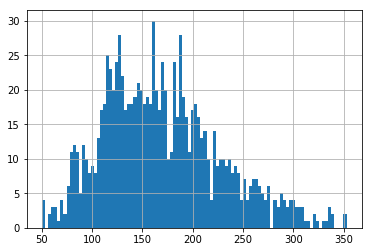

In [8]:
final_df['Total_gCO2_MJ_net'].hist(bins=100)